## Mykolaiv news analysis

#### Contex
Analyse news from the local magazine <b><a href="https://vn.mk.ua/ru/glavnaya/">Вечерний Николаев</a></b><br/>
<a href="https://vn.mk.ua/ru/arhiv/">Archive pages</a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import requests
import polyglot
from polyglot.text import Text
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# For Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# For Classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from tqdm.notebook import tqdm
# progress bar when apply functions to dataframe
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

from polyglot.detect.base import logger as polyglot_logger
polyglot_logger.setLevel("ERROR")

archive_pages_file = './pages.json'
articles_dir = './articles'
ukrainian_stop_words_url = 'https://raw.githubusercontent.com/skupriienko/Ukrainian-Stopwords/master/stopwords_ua_list.txt'

#### Load and prepare data

In [2]:
df = pd.read_json(archive_pages_file)
df

,page_url,href,title,date,category
0,https://vn.mk.ua/ru/arhiv/page/1,https://vn.mk.ua/ru/kogtetochki-dlya-kotov-vaz...,Когтеточки для котов: важный элемент ухода и р...,2024-01-29 10:53:00,Полезно знать
1,https://vn.mk.ua/ru/arhiv/page/1,https://vn.mk.ua/ru/chto-takoe-hotvilsy-i-kako...,Что такое хотвилсы и каков их ассортимент?,2024-01-26 10:26:00,Полезно знать
2,https://vn.mk.ua/ru/arhiv/page/1,https://vn.mk.ua/ru/chem-otlichaetsya-brendi-o...,Чем отличается бренди от коньяка,2024-01-15 20:42:00,Это интересно
3,https://vn.mk.ua/ru/arhiv/page/1,https://vn.mk.ua/ru/spotovaya-i-fyuchersnaya-t...,Спотовая и фьючерсная торговля: разница,2024-11-01 16:55:00,Полезно знать
4,https://vn.mk.ua/ru/arhiv/page/1,https://vn.mk.ua/ru/optimizatsiya-zatrat-na-re...,Оптимизация затрат на ремонт ходовой: практиче...,2023-12-27 11:31:00,Полезно знать
...,...,...,...,...,...
15246,https://vn.mk.ua/ru/arhiv/page/1525,https://vn.mk.ua/ru/zadvorki-paradnoj-ulitsy/,Задворки “парадной” улицы,2019-03-22 14:37:00,Почитаем
15247,https://vn.mk.ua/ru/arhiv/page/1525,https://vn.mk.ua/ru/sessiya-gorsoveta-opyat-po...,Сессия горсовета: опять помешали,2019-03-21 18:01:00,Размышляем вместе
15248,https://vn.mk.ua/ru/arhiv/page/1525,https://vn.mk.ua/ru/o-chem-pishut-v-internete/,О чем пишут в Интернете,2019-03-21 16:31:00,Взгляд
15249,https://vn.mk.ua/ru/arhiv/page/1525,https://vn.mk.ua/ru/yuzhnokorejskij-trejder-ku...,Южнокорейский трейдер купил терминал в Николаеве,2019-03-21 15:13:00,Об этом говорят


In [3]:
def get_article_name(url):
    return url.strip('/').split('/')[-1]

def remove_header(content):
    parts = content.split("\n\n \n\n\n\n", 1)
    if len(parts) == 2:
        return parts[1]
    return content
    
def get_article_content(url):
    name = get_article_name(url)
    file_path = os.path.join(articles_dir, name)
    if not os.path.exists(file_path):
        return None

    with open(file_path, 'r') as f:
        return remove_header(f.read())

In [4]:
# Add content column
df2 = df.drop(columns=['page_url', 'href', 'date'], axis=1)
df2['content'] = df['href'].apply(get_article_content)
df2

,title,category,content
0,Когтеточки для котов: важный элемент ухода и р...,Полезно знать,Коты являются замечательными домашними питомца...
1,Что такое хотвилсы и каков их ассортимент?,Полезно знать,"Многих интересует, что же интересного подарить..."
2,Чем отличается бренди от коньяка,Это интересно,"Коньяк и бренди — крепкие алкогольные напитки,..."
3,Спотовая и фьючерсная торговля: разница,Полезно знать,Когда вы только начинаете знакомиться с крипто...
4,Оптимизация затрат на ремонт ходовой: практиче...,Полезно знать,Обеспечение надежности и безопасности вашего а...
...,...,...,...
15246,Задворки “парадной” улицы,Почитаем,– На «Розочке» остановите! – несется на всю ма...
15247,Сессия горсовета: опять помешали,Размышляем вместе,\nЦветы – Сергею Бондаренко\nВ минувший четвер...
15248,О чем пишут в Интернете,Взгляд,"\nПИСЬМО ИЗ ФИНЛЯНДИИ Есть тексты, которые пр..."
15249,Южнокорейский трейдер купил терминал в Николаеве,Об этом говорят,\n Корейская компания Posco Daewoo 12 февраля ...


In [5]:
# modify columns types
print(df2['category'].value_counts()[:10])
df2['content'] = df2['content'].astype('string')
df2 = df2.dropna()
df2.info()

category
Актуально           3260
В Украине и мире    2342
Город и люди         802
Стало известно       633
Будни власти         600
ВОЙНА                594
Болевая точка        485
В фокусе             460
Без рубрики          442
Карантин-2022        441
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 14963 entries, 0 to 15250
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     14963 non-null  object
 1   category  14963 non-null  object
 2   content   14963 non-null  string
dtypes: object(2), string(1)
memory usage: 467.6+ KB


In [6]:
# leave only 9 categories
most_frequent = df2['category'].value_counts()[:9].index.to_list()
df2 = df2[df2['category'].isin(most_frequent)]
df2['category'] = df2['category'].astype('category')

### Text preprocessing

In [7]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('vader_lexicon')

#### Lower Casing, Removal Punctuations, Removal of stopwords

In [8]:
df3 = df2.copy()
df3.reset_index(inplace = True, drop = True)

In [9]:
# Load Ukraininan Stop Words
response = requests.get(ukrainian_stop_words_url)
ukrainian_stop_words = [s.strip() for s in response.text[1:-1].replace("\'", '').split(',')]
ukrainian_stop_words[:10]

['а',
 'аби',
 'абиде',
 'абиким',
 'абикого',
 'абиколи',
 'абикому',
 'абикуди',
 'абихто',
 'абичий']

In [10]:
# Lower Casing
df3['content_new'] = df3['content'].str.lower().replace('\n', ' ')
# Removal of Punctuations
df3['content_new'] = df3['content_new'].progress_apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))
# Removal of stopwords 
stopwords = nltk.corpus.stopwords.words('russian') + ukrainian_stop_words
df3['content_new'] = df3['content_new'].progress_apply(lambda text: " ".join([word for word in text.split() if word not in stopwords]))
df3.head()

  0%|          | 0/9617 [00:00<?, ?it/s]

  0%|          | 0/9617 [00:00<?, ?it/s]

,title,category,content,content_new
0,Microsoft купила Call of Duty: как это случилось?,Стало известно,Microsoft купила Call of Duty: как это случил...,microsoft купила call of duty это случилось 27...
1,О чем пишут в интернете,Стало известно,"И ВОТ ОНА, НАРЯДНАЯ, НА ПРАЗДНИК НЕ ПРИШЛА… В ...",нарядная праздник пришла… николаевском сегмент...
2,Миколаївський зоопарк: важкі місяці 2022-го,Город и люди,«Місяці війни. Миколаївський зоопарк». Таку на...,«місяці війни миколаївський зоопарк» назву отр...
3,Читаем свежую информацию на украинской версии ...,В фокусе,"Для получения актуальной и свежей информации, ...",получения актуальной свежей информации пожалуй...
4,60% россиян поддержали бы “новое наступление н...,В Украине и мире,Возможное решение Владимира Путина начать “нов...,возможное решение владимира путина начать “нов...


#### Tokenize and Stemming

In [11]:
stemmer = nltk.stem.SnowballStemmer("russian")
df3['content_new'] = df3['content_new'].progress_apply(lambda text: " ".join([stemmer.stem(word) for word in nltk.tokenize.word_tokenize(text)]))
df3.head()

  0%|          | 0/9617 [00:00<?, ?it/s]

,title,category,content,content_new
0,Microsoft купила Call of Duty: как это случилось?,Стало известно,Microsoft купила Call of Duty: как это случил...,microsoft куп call of duty эт случ 27112023 10...
1,О чем пишут в интернете,Стало известно,"И ВОТ ОНА, НАРЯДНАЯ, НА ПРАЗДНИК НЕ ПРИШЛА… В ...",нарядн праздник пришла… николаевск сегмент фей...
2,Миколаївський зоопарк: важкі місяці 2022-го,Город и люди,«Місяці війни. Миколаївський зоопарк». Таку на...,« місяці війн миколаївськ зоопарк » назв отрим...
3,Читаем свежую информацию на украинской версии ...,В фокусе,"Для получения актуальной и свежей информации, ...",получен актуальн свеж информац пожалуйст обращ...
4,60% россиян поддержали бы “новое наступление н...,В Украине и мире,Возможное решение Владимира Путина начать “нов...,возможн решен владимир путин нача “ нов наступ...


### Exploration Analysis

In [12]:
# Fit TF-IDF vectorizer
tfidf = TfidfVectorizer(min_df=0.005)
tfidf_vect = tfidf.fit_transform(df3['content_new']);

# Store dataframe
tfidf_df = pd.DataFrame(tfidf_vect.toarray(), columns=tfidf.get_feature_names_out())
# Insert category column in TF-IDF matrix
tfidf_df['category'] = df3['category']
print(tfidf_df.shape)
tfidf_df.head()

(9617, 3951)


,000,0512,10,100,1000,101,102,103,105,11,...,январ,япон,японск,ярк,ясн,яхтклуб,інформаці,інформаціє,інфраструктур,category
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022114,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Стало известно
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.032274,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Стало известно
2,0.0,0.0,0.009853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.037939,0.0,0.0,Город и люди
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,В фокусе
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,В Украине и мире


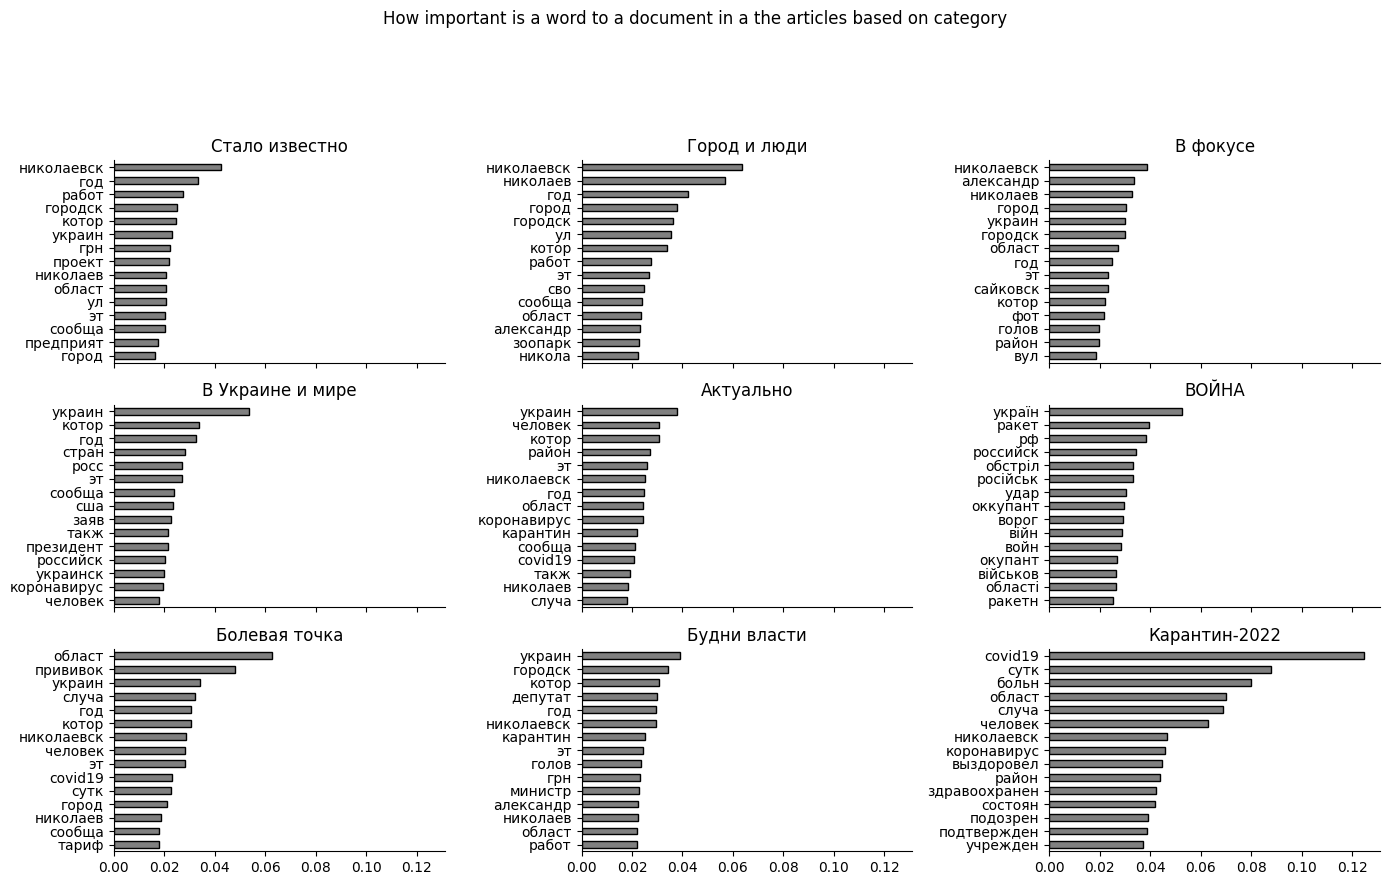

In [13]:
# Get unqiue categories
categories = tfidf_df['category'].unique().tolist()
# Initialize plots
fig, axes = plt.subplots(3, 3, figsize=(14, 8), sharex=True)

for cat, ax in enumerate(axes.flatten()):
  
    # Sort words by hight TF-IDF mean and by category
    top = tfidf_df[tfidf_df['category'] == categories[cat]].iloc[:, :-1].mean().sort_values().tail(15)
  
    # Bar plot most imporant words for every category
    top.plot(kind="barh", ax=ax, title=categories[cat], color="gray", edgecolor="k")

# Plot meta data
fig.suptitle("How important is a word to a document in a the articles based on category", y=1.1)
fig.tight_layout()

sns.despine()

### Sentiment Analysis

In [14]:
# !apt install libicu-dev
# !python3-tk
# !pip3 install polyglot
# !pip3 install pyicu
# !pip3 install pycld2
# !pip3 install morfessor
# !polyglot download sentiment2.en
# !polyglot download sentiment2.ru
#!polyglot download sentiment2.uk

In [15]:
def add_polarity(text):
    try:
        return Text(text).polarity
    except:
        return 0

In [16]:
polarity_serires = df3['content'].progress_apply(add_polarity)

  0%|          | 0/9617 [00:00<?, ?it/s]

In [17]:
polarity_df = polarity_serires.to_frame()
polarity_df['category'] = df3['category']
polarity_df.rename(columns={'content': 'polarity'}, inplace=True)
polarity_df.head()

,polarity,category
0,0.106383,Стало известно
1,0.333333,Стало известно
2,-0.081967,Город и люди
3,0.000000,В фокусе
4,0.692308,В Украине и мире


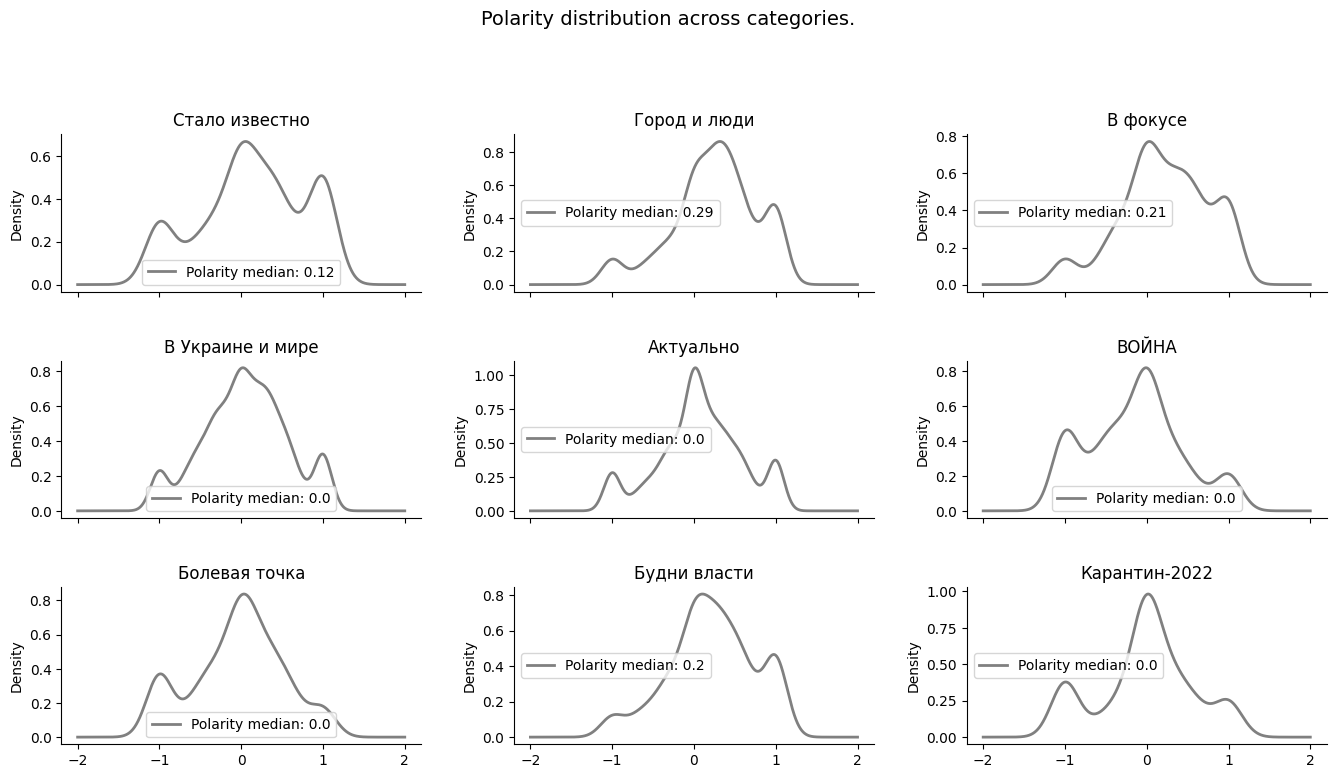

In [18]:
# Initialize plots
fig, axes = plt.subplots(3, 3, figsize=(14, 8), sharex=True)
# Loop over axes and plot category
for cat, ax in enumerate(axes.flatten()):
    # Select df with dataframe
    category_df = polarity_df[polarity_df['category'] == categories[cat]].polarity

    # Bar plot word count category
    category_df.plot(kind="kde",
                     ax=ax, color="gray",
                     lw=2,
                     title=f"{categories[cat]}",
                     label=f"Polarity median: {round(category_df.median(), 2)}")
    ax.legend()

# Plot meta data
fig.suptitle("Polarity distribution across categories.", fontsize=14, y=1)
fig.tight_layout(pad=3)

sns.despine();

### Text Clusterization

In [15]:
X = tfidf_df.drop(columns=['category'], axis=1)

#### Calculate clusters count

In [16]:
def get_metrics(X, clusters):
    distortions = []
    silhouette = []

    for k in tqdm(clusters):
        kmean = KMeans(n_clusters=k, random_state=7)
        kmean.fit(X)
        distortions.append(kmean.inertia_)
    
        preds = kmean.predict(X)
        silhouette.append(silhouette_score(X, preds))

    return (distortions, silhouette)

def show_metrics(X, clusters):
    distortions, silhouette = get_metrics(X, clusters)

    plt.figure(figsize=(20,5))
    plt.plot(clusters, distortions, '-',color='g')
    plt.xlabel('k values')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    plt.figure(figsize=(20,5))
    plt.plot(clusters, silhouette, '-',color='g')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette score of each k values')
    plt.show()  

  0%|          | 0/8 [00:00<?, ?it/s]

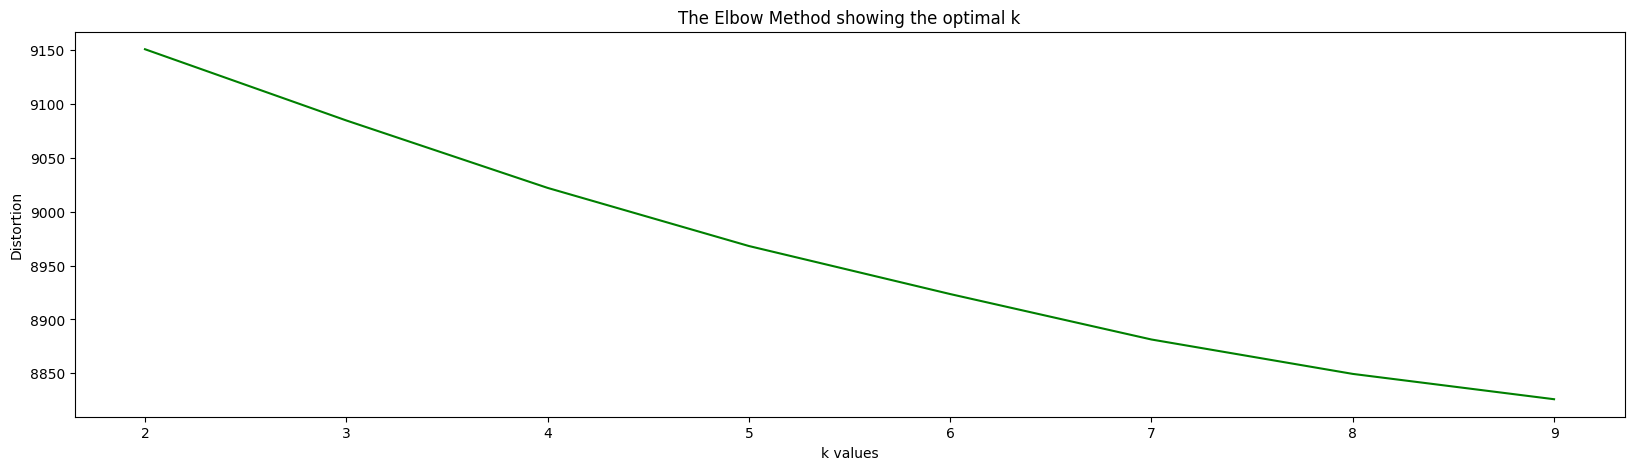

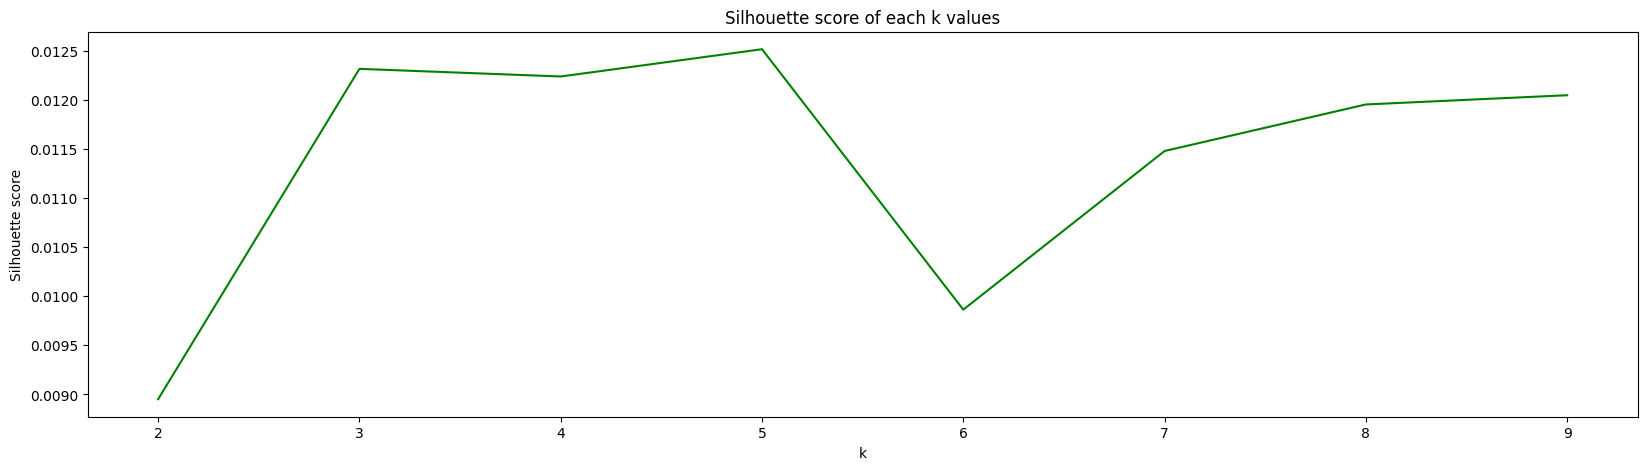

In [17]:
show_metrics(X, range(2, 10))

#### Calculate clusters count after PCA

  0%|          | 0/8 [00:00<?, ?it/s]

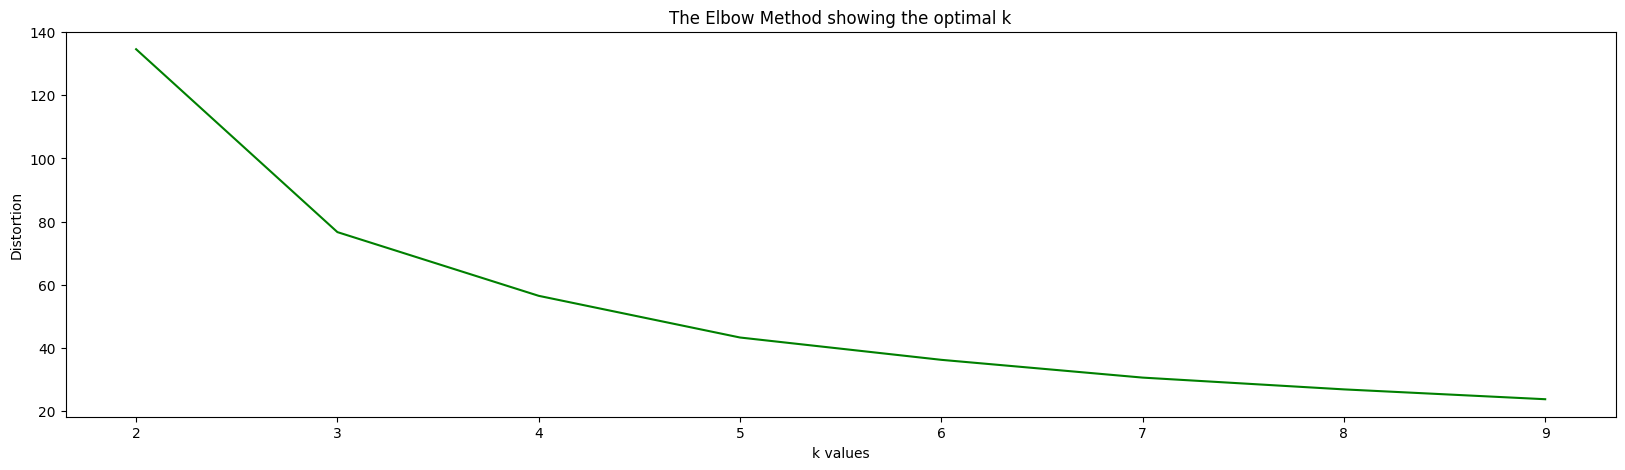

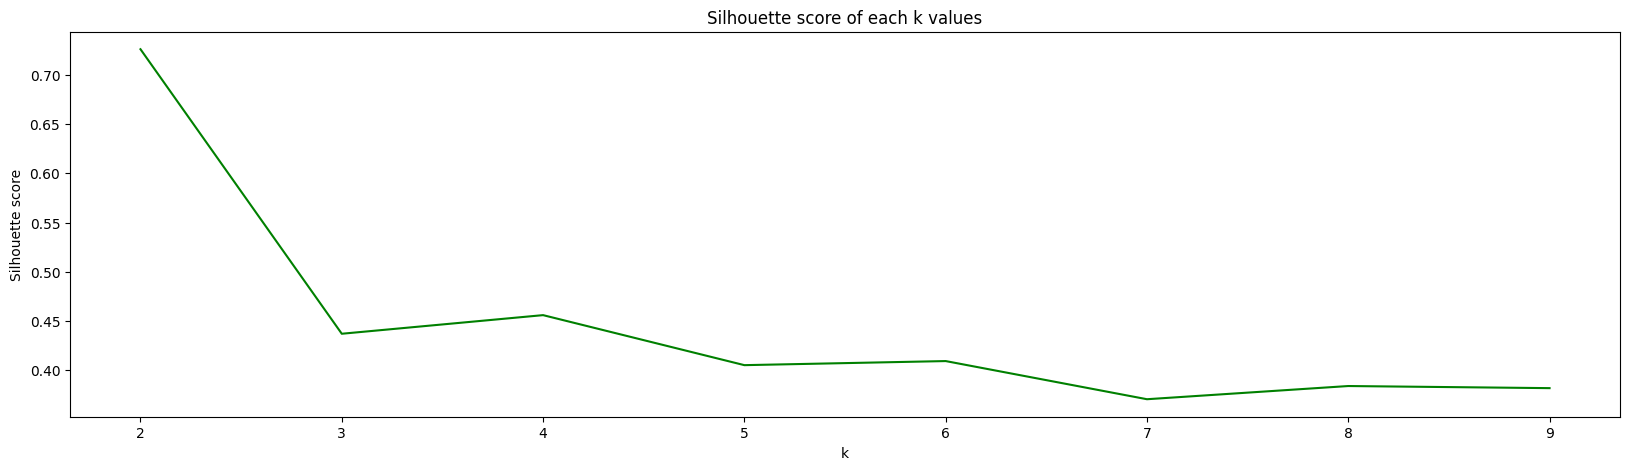

In [18]:
# Use PCA to determinate clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

show_metrics(X_pca, range(2, 10))

Text(0.5, 1.0, 'scatter plot')

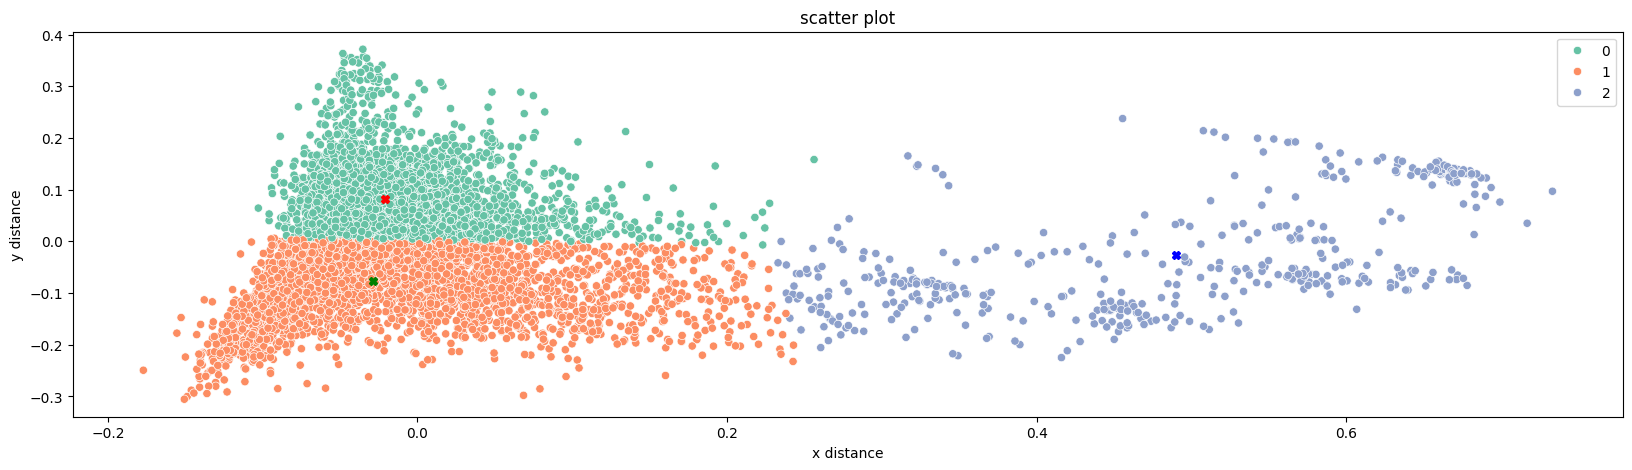

In [27]:
# Show clusters
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(X_pca)
pred_labels = kmeanModel.labels_;
pred_centers = kmeanModel.cluster_centers_
df_centers = pd.DataFrame(pred_centers, columns=['x', 'y'])
df_pca = pd.DataFrame(X_pca, columns=['x', 'y'])


plt.figure(figsize=(20,5))

sns.scatterplot(data=df_pca, x='x', y='y', hue=pred_labels.tolist(),palette='Set2')
colors = ['red', 'green', 'blue']

for i,color in enumerate(df_centers.index.tolist()):
    plt.plot(df_centers['x'][i], df_centers['y'][i], 'X', label='K-means center: %d' % i, color=colors[i])
plt.xlabel('x distance')
plt.ylabel('y distance')
plt.title('scatter plot')

In [28]:
# add cluster labels to score df
tfidf_df2 = tfidf_df.drop(columns=['category'], axis=1)
tfidf_df2['cluster'] = pred_labels
tfidf_df2['cluster'] = tfidf_df2['cluster'].astype('category')

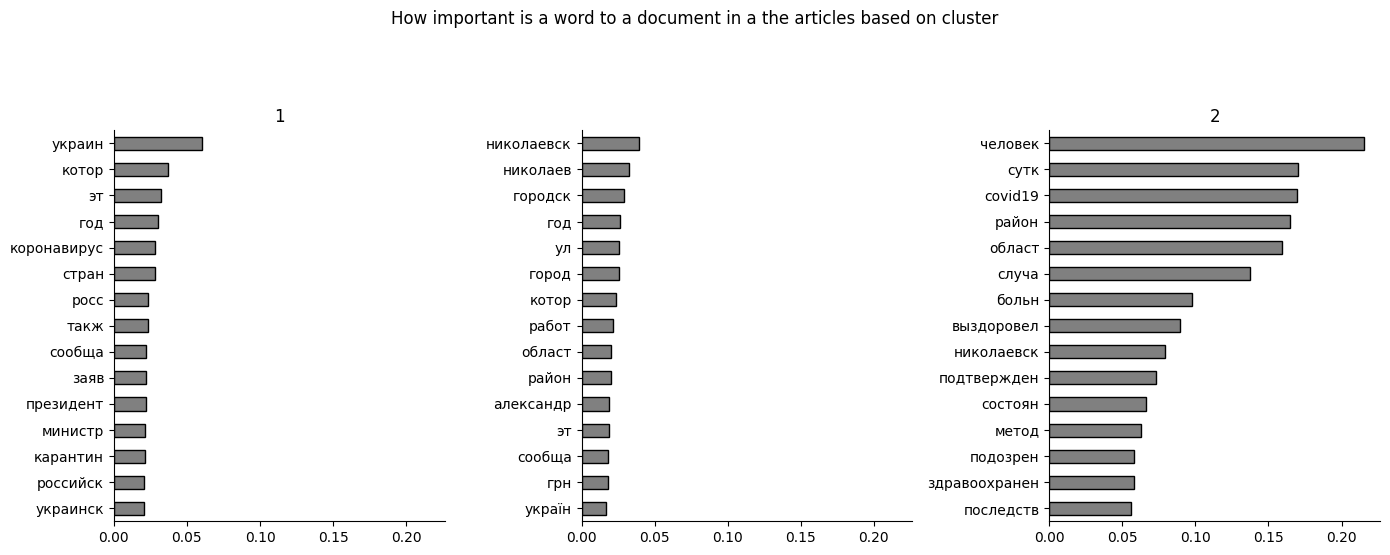

In [29]:
# Get unqiue categories
clusters = tfidf_df2['cluster'].unique().tolist()
# Initialize plots
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharex=True)

for cat, ax in enumerate(axes.flatten()):
  
    # Sort words by hight TF-IDF mean and by category
    top = tfidf_df2[tfidf_df2['cluster'] == clusters[cat]].iloc[:, :-1].mean().sort_values().tail(15)
  
    # Bar plot most imporant words for every category
    top.plot(kind="barh", ax=ax, title=clusters[cat], color="gray", edgecolor="k")

# Plot meta data
fig.suptitle("How important is a word to a document in a the articles based on cluster", y=1.1)
fig.tight_layout()

sns.despine()

### Text Classificaton

In [30]:
X = X_pca
y = pred_labels

In [31]:
def get_metrics(x, y, model, label):
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
    model.fit(X_train, y_train)

    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    return {"model": label,
            "accuracy train": "%.2f" % metrics.accuracy_score(y_train, y_hat_train),
            "accuracy test": "%.2f" % metrics.accuracy_score(y_test, y_hat_test),
            "precision train (macro)": "%.2f" % metrics.precision_score(y_train, y_hat_train, average = 'macro', zero_division=0),
            "precision test (macro)": "%.2f" % metrics.precision_score(y_test, y_hat_test, average = 'macro', zero_division=0),
            "precision train (micro)": "%.2f" % metrics.precision_score(y_train, y_hat_train, average = 'micro', zero_division=0),
            "precision test (micro)": "%.2f" % metrics.precision_score(y_test, y_hat_test, average = 'micro', zero_division=0),
            "recall train (macro)": "%.2f" % metrics.recall_score(y_train, y_hat_train, average = 'macro', zero_division=0),
            "recall test (macro)": "%.2f" % metrics.recall_score(y_test, y_hat_test, average = 'macro', zero_division=0),
            "recall train (micro)": "%.2f" % metrics.recall_score(y_train, y_hat_train, average = 'micro', zero_division=0),
            "recall test (micro)": "%.2f" % metrics.recall_score(y_test, y_hat_test, average = 'micro', zero_division=0)}
    

In [32]:
models = {"LogisticRegression": LogisticRegression(max_iter=2000),
          "DecisionTreeClassifier": DecisionTreeClassifier(),    
          "SVC": SVC(kernel="linear", C=0.025)      
         }

series = []
for label, model in models.items():
    metrics_ = get_metrics(X, y, model, label)
    series.append(pd.Series(metrics_))
    print("Handled", label)

mdf = pd.concat(series, axis=1).T.set_index("model")
mdf

Handled LogisticRegression
Handled DecisionTreeClassifier
Handled SVC


,accuracy train,accuracy test,precision train (macro),precision test (macro),precision train (micro),precision test (micro),recall train (macro),recall test (macro),recall train (micro),recall test (micro)
model,,,,,,,,,,
LogisticRegression,0.98,0.98,0.99,0.99,0.98,0.98,0.96,0.95,0.98,0.98
DecisionTreeClassifier,1.00,0.99,1.00,0.99,1.00,0.99,1.00,0.99,1.00,0.99
SVC,0.98,0.97,0.98,0.98,0.98,0.97,0.88,0.87,0.98,0.97


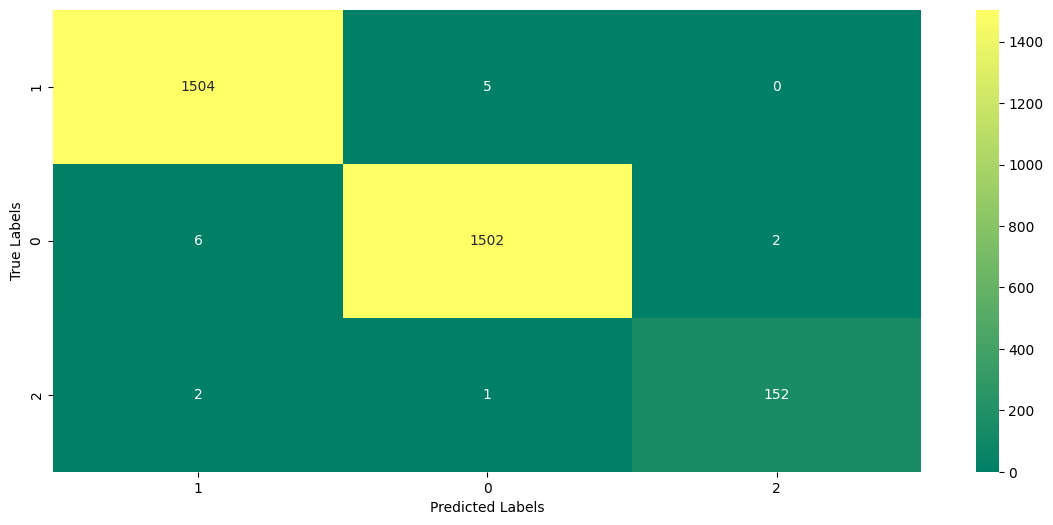

In [34]:
best_model = "DecisionTreeClassifier" # KNN_grid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
y_hat = models[best_model].fit(X_train, y_train).predict(X_test)
y_score = models[best_model].fit(X_train, y_train).predict_proba(X_test)

plt.figure(figsize = (14,6))
sns.heatmap(metrics.confusion_matrix(y_test, y_hat), annot = True, fmt="d",
            xticklabels = clusters, yticklabels = clusters, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()